# Pancreatic endocrinogenesis

In [1]:
import random
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn 

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


In [3]:
# run dynamo to get RNA velocity 
dyn.configuration.set_figure_params('dynamo', background='white')
adata = dyn.sample_data.pancreatic_endocrinogenesis()

|-----> Downloading data to ./data/endocrinogenesis_day15.h5ad


In [4]:
pancreas_genes = ["Hes1","Nkx6-1","Nkx2-2","Neurog3","Neurod1","Pax4","Pax6","Arx","Pdx1","Ins1","Ins2","Ghrl","Ptf1a","Iapp","Isl1", "Sox9","Gcg"]

dyn.pp.recipe_monocle(adata, n_top_genes=4000, fg_kwargs={"shared_count": 20}, genes_to_append=pancreas_genes)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

In [5]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes'
    obsm: 'X_pca', 'X_umap', 'X', 'cell_cycle_scores'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'
    obsp: 'distances', 'connectivities'

In [6]:
dyn.tl.dynamics(adata, model='static')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [18.3744s]


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics'
    obsm: 'X_pca', 'X_umap', 'X', 'cell_cycle_scores'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced

<br><br><br>
## Inputting ds/dt from cellDancer to dynamo.

In [7]:
import pandas as pd 
import numpy as np
import scipy

dancer_df = pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/analysis/CaseStudyNotebook/your_path/PancreaticEndocrinogenesis_cellDancer_estimation.csv')

In [8]:
dancer_genes = dancer_df['gene_name'].drop_duplicates()

In [9]:
dancer_df["velocity_S"] = dancer_df["splice_predict"]-dancer_df["splice"]
dancer_velocity_s = dancer_df[['cellID', 'gene_name', 'velocity_S']]
pivoted = dancer_velocity_s.pivot(index="cellID", columns="gene_name", values="velocity_S")
velocity_matrix = np.zeros(adata.shape)
adata_ds_zeros = pd.DataFrame(velocity_matrix, columns=adata.var.index, index=adata.obs.index)
celldancer_velocity_s_df = (adata_ds_zeros + pivoted).fillna(0)[adata.var.index]


In [10]:
adata.layers['velocity_S'] = scipy.sparse.csr_matrix(celldancer_velocity_s_df.values)

In [11]:
adata.var['use_for_dynamics'] = adata.var.index.isin(dancer_genes)
adata.var['use_for_transition'] = adata.var.index.isin(dancer_genes)

In [12]:
# import celldancer.cdplt as cdplt
# pancreas_cluster_cmap = cdplt.colormap.colormap_pancreas
pancreas_cluster_cmap = {'Ductal': '#3361A5',
 'Ngn3 low EP': '#248AF3',
 'Ngn3 high EP': '#14B3FF',
 'Pre-endocrine': '#88CEEF',
 'Alpha': '#ff4800',
 'Beta': '#B81136',
 'Delta': 'green',
 'Epsilon': '#03B3B0'}

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0024s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [14.5911s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [1.0056s]
|-----> 0 genes are removed because of nan velocity values.
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector t

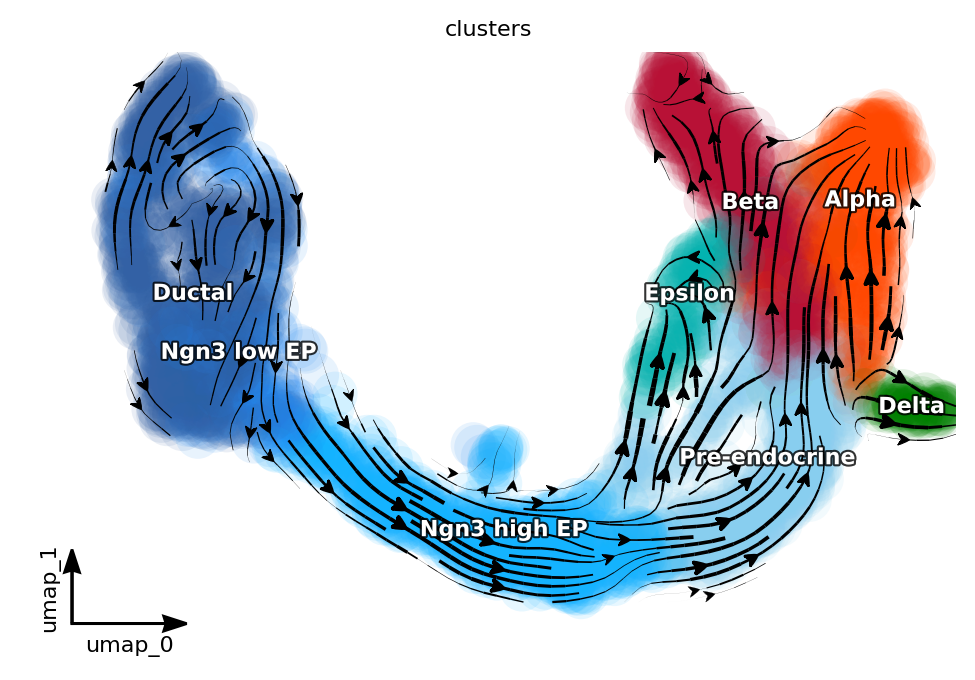

In [13]:
dyn.tl.reduceDimension(adata, n_pca_components=30)
dyn.tl.cell_velocities(adata, method="pearson", other_kernels_dict={"transform": "sqrt"})
dyn.tl.cell_velocities(adata, basis="pca")

dyn.pl.streamline_plot(adata, color=["clusters"], basis="umap", color_key = pancreas_cluster_cmap, show_legend="on data", show_arrowed_spines=True)

In [14]:
dyn.vf.VectorField(adata, basis="pca", pot_curl_div=True)
dyn.vf.VectorField(adata, basis="umap", pot_curl_div=True)

dyn.vf.speed(adata, basis="pca")
dyn.vf.divergence(adata, basis="pca")
dyn.vf.acceleration(adata, basis="pca")
dyn.vf.curl(adata, basis="umap")

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.2664s]
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> graphizing vectorfield...
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from la

Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00,  9.81it/s]

|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.


|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [20.4569s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.4521s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------? nbrs_idx argument is ignored and recomputed because nbrs_idx is not None and retur

Calculating 2-D curl: 100%|██████████████| 3696/3696 [00:00<00:00, 15703.93it/s]

|-----> Computing divergence...



Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00, 21.92it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [23.7250s]


Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00,  5.75it/s]


|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1907s]
|-----> <insert> acceleration to layers in AnnData Object.


Calculating 2-D curl: 100%|██████████████| 3696/3696 [00:00<00:00, 16773.69it/s]


|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


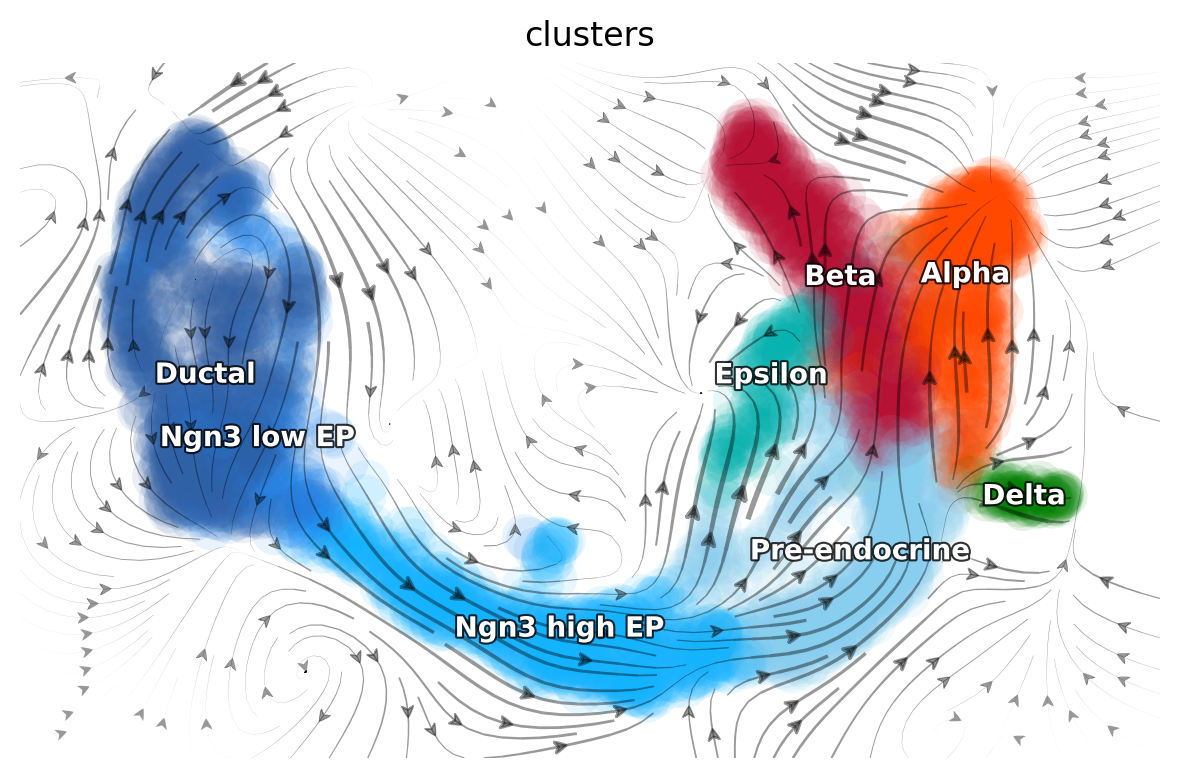

In [15]:
dyn.pl.topography(adata, color=['clusters'], basis='umap', background='white', 
                  streamline_color='black', color_key = pancreas_cluster_cmap, show_legend='on data', terms=("streamline"))

|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


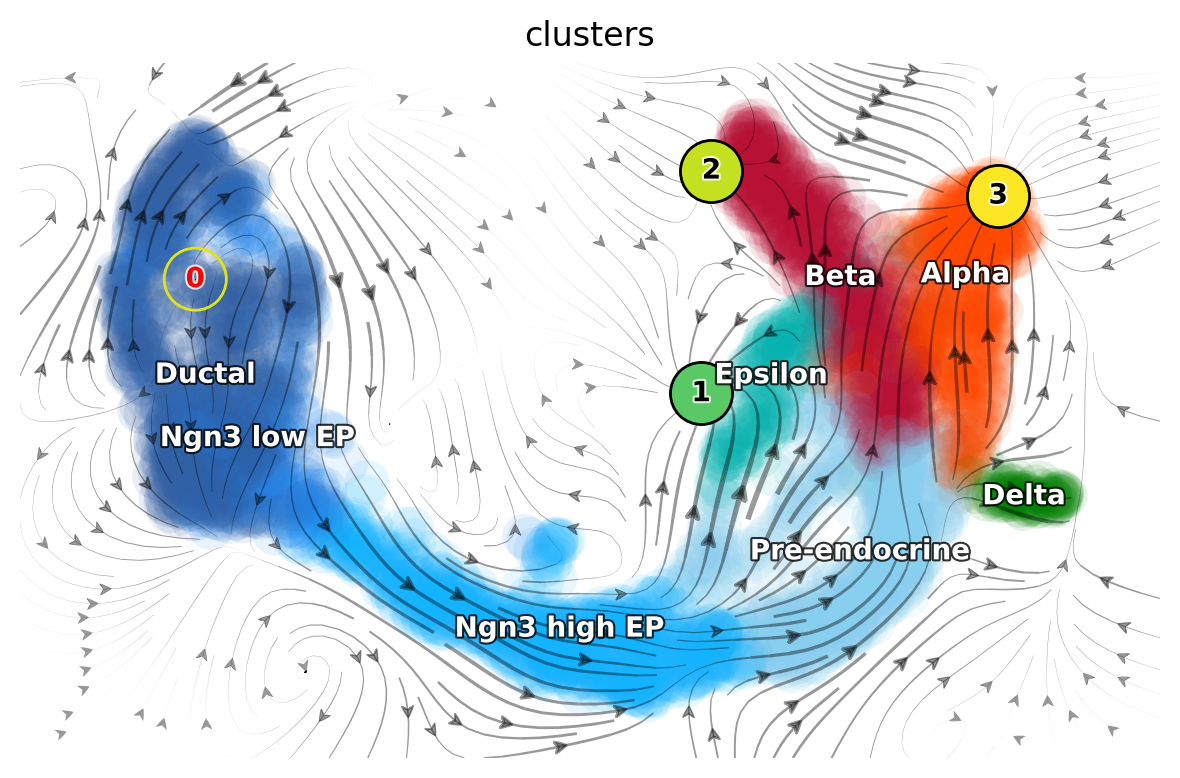

In [16]:
adata_load_fix_points=adata.copy()
Xss, ftype, conf = adata_load_fix_points.uns['VecFld_umap']['Xss'],\
             adata_load_fix_points.uns['VecFld_umap']['ftype'],\
             adata_load_fix_points.uns['VecFld_umap']['confidence']
    
good_fixed_points = [10,7,16,12]

adata_load_fix_points.uns['VecFld_umap']['Xss'] = Xss[good_fixed_points]
adata_load_fix_points.uns['VecFld_umap']['ftype'] = ftype[good_fixed_points]
adata_load_fix_points.uns['VecFld_umap']['confidence']=conf[good_fixed_points]

dyn.pl.topography(
    adata_load_fix_points,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    color_key = pancreas_cluster_cmap, 
    color=["clusters"],
    show_legend='on data',    
    save_show_or_return='show'
)

Transforming subset Jacobian: 100%|█████| 3696/3696 [00:00<00:00, 102549.81it/s]


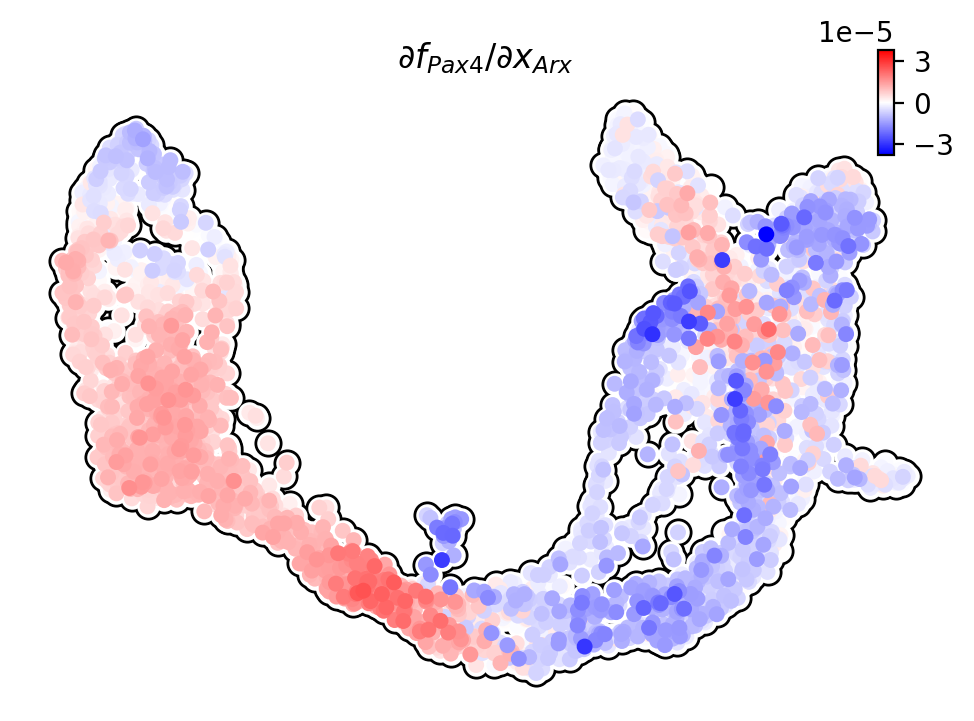

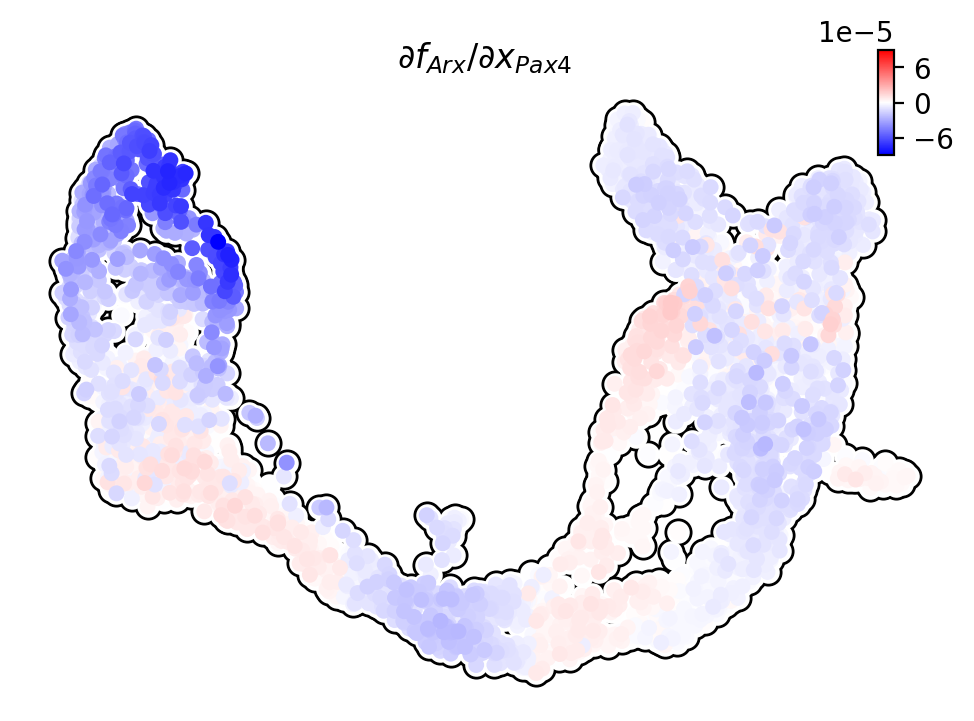

In [17]:
dyn.vf.jacobian(adata, regulators=['Arx','Pax4'])

dyn.pl.jacobian(
    adata,
    basis="umap",
    regulators=[
        'Arx',
    ],
    effectors=['Pax4'],
    alpha=1,
)

dyn.pl.jacobian(
    adata,
    basis="umap",
    regulators=[
        'Pax4',
    ],
    effectors=['Arx'],
    alpha=1,
)

|-----------> plotting with basis key=X_umap


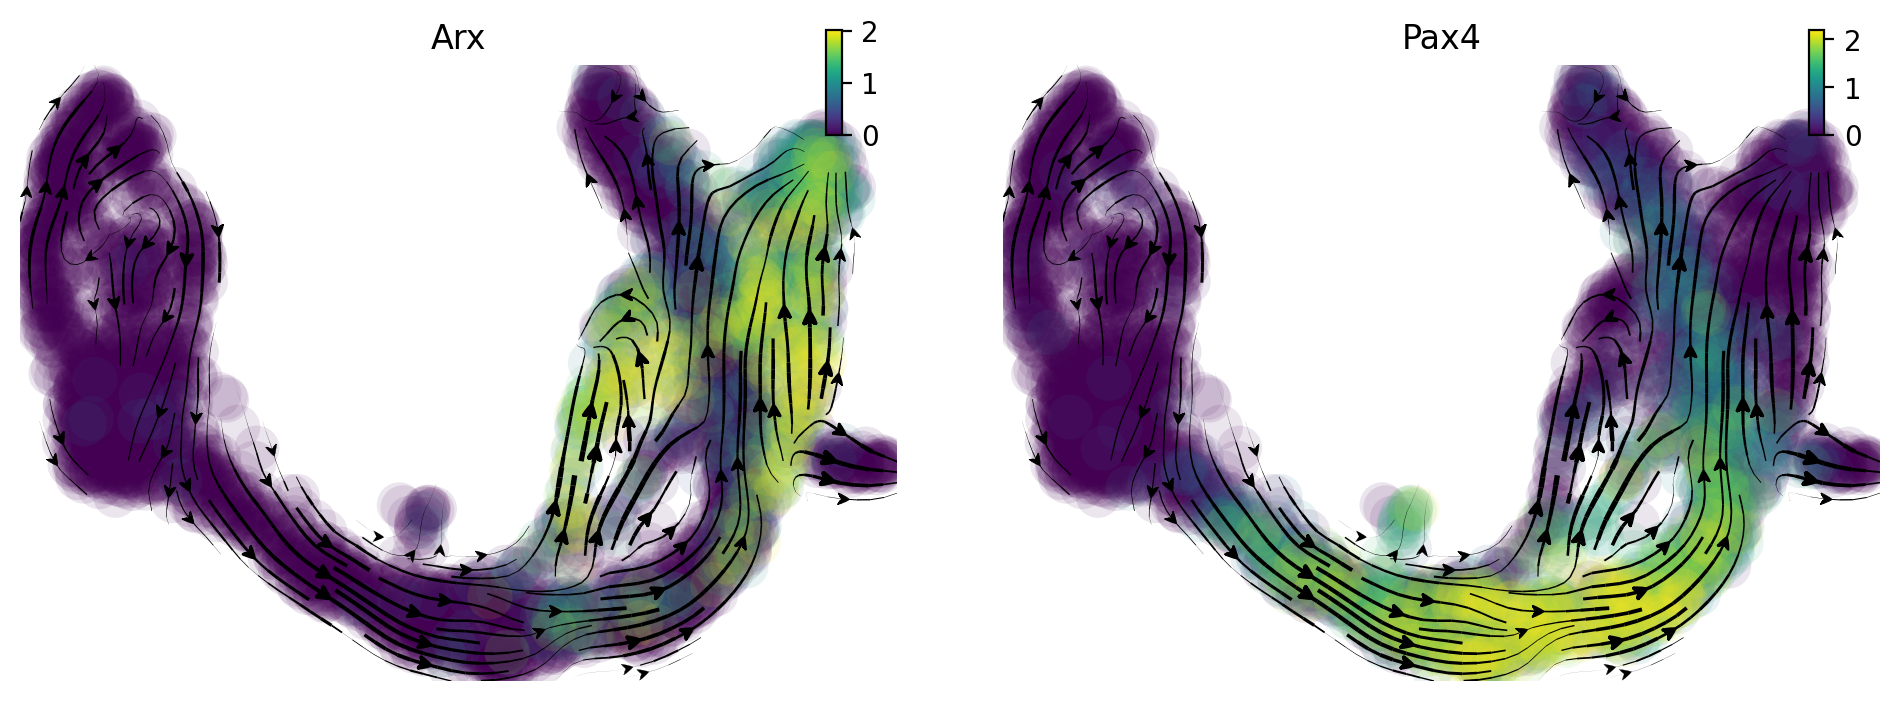

In [18]:
dyn.pl.streamline_plot(
    adata,
    color=["Arx",'Pax4'],
    ncols=4,
    basis="umap",
)